In [1]:
import os
import tarfile
import shutil
from tqdm import tqdm

# Define paths
source_dir = "."  # Current directory
output_dir = "merged_images"  # Folder to store all images

# Create output directory if not exists
os.makedirs(output_dir, exist_ok=True)

# Get list of all .tar.gz files
tar_files = sorted([f for f in os.listdir(source_dir) if f.endswith(".tar.gz")])

# Extract and merge images
for tar_file in tqdm(tar_files, desc="Extracting files"):
    tar_path = os.path.join(source_dir, tar_file)
    
    # Open tar.gz file
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall("temp_extracted")

    # Move images to the merged folder
    for root, _, files in os.walk("temp_extracted"):
        for file in files:
            src_path = os.path.join(root, file)
            dst_path = os.path.join(output_dir, file)
            
            # Ensure no file name conflicts
            if os.path.exists(dst_path):
                base, ext = os.path.splitext(file)
                counter = 1
                while os.path.exists(dst_path):
                    dst_path = os.path.join(output_dir, f"{base}_{counter}{ext}")
                    counter += 1
            
            shutil.move(src_path, dst_path)

    # Cleanup extracted temporary directory
    shutil.rmtree("temp_extracted")

print(f"All images have been merged into '{output_dir}'.")


Extracting files:   0%|                                                                          | 0/12 [00:00<?, ?it/s]/var/folders/0m/fx3127cx38nbdzfcwxkgjtb80000gn/T/ipykernel_33746/1317662822.py:22: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("temp_extracted")
Extracting files: 100%|█████████████████████████████████████████████████████████████████| 12/12 [01:43<00:00,  8.62s/it]

All images have been merged into 'merged_images'.


In [12]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from tqdm import tqdm

# Load Pretrained ResNet50 (without classification layer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove last layer
model = model.to(device)
model.eval()

# Define Image Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Directory with images
image_dir = "merged_images"
data = []

# Process all images
for image_name in tqdm(os.listdir(image_dir), desc="Vectorizing Images"):
    image_path = os.path.join(image_dir, image_name)
    
    try:
        # Open and preprocess image
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        
        # Extract feature vector
        with torch.no_grad():
            vector = model(image).squeeze().cpu().numpy()

        # Store image name and vectorized features
        data.append([image_name] + vector.tolist())
    
    except Exception as e:
        print(f"Error processing {image_name}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data)

# Rename columns: First column = "image_name", Rest = "feature_1", "feature_2", ...
df.columns = ["image_name"] + [f"feature_{i}" for i in range(df.shape[1] - 1)]

# Save DataFrame to CSV
df.to_csv("image_vectors.csv", index=False)

print("Vectorized image dataset saved as 'image_vectors.csv'.")


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/diyapati/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 75.9MB/s]
Vectorizing Images: 100%|█████████████████████████████████████████████████████| 112120/112120 [1:13:31<00

Vectorized image dataset saved as 'image_vectors.csv'.


In [16]:
df.head(10)

,image_name,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_2038,feature_2039,feature_2040,feature_2041,feature_2042,feature_2043,feature_2044,feature_2045,feature_2046,feature_2047
0,00018805_001.png,0.418487,0.306601,0.801291,0.044648,0.607149,0.503188,0.556803,0.409647,0.551391,...,0.204681,0.078678,0.227979,0.145360,0.125559,0.100496,0.033357,0.070022,0.511545,0.360500
1,00005868_002.png,0.373129,0.462354,1.194659,0.144330,0.310254,1.676204,0.455906,0.273282,0.828891,...,0.308831,0.009194,0.044123,0.297138,0.610502,0.094704,0.191540,0.219701,1.179693,0.648014
2,00009663_000.png,0.050278,0.744042,1.508330,0.488489,0.378242,0.385282,0.224698,0.122177,0.159800,...,0.169191,0.000791,0.007508,0.506602,0.230475,0.250326,0.054024,0.078933,0.257028,0.110671
3,00022156_007.png,0.066088,0.777098,1.181380,0.404282,0.221584,0.366294,0.410837,0.117063,0.229142,...,0.247339,0.027537,0.042472,0.147641,0.250765,0.095297,0.134013,0.236017,0.210253,1.181115
4,00005395_004.png,0.041102,0.181218,0.742273,0.150364,0.119664,0.148466,0.248920,0.109956,0.305178,...,0.144721,0.013806,0.025944,0.141631,0.354130,0.111998,0.050722,0.037256,0.512696,0.782948
5,00006966_004.png,0.159714,1.358857,1.306791,0.197567,0.075864,0.826678,0.572982,0.374754,0.360177,...,0.372673,0.117993,0.094834,0.351271,0.822779,0.061681,0.059519,0.708100,1.156346,0.380706
6,00000324_013.png,0.191458,0.545136,1.048456,0.539831,0.424234,0.826224,0.434510,0.240744,0.083549,...,0.064091,0.127144,0.048714,0.288780,0.361534,0.051720,0.000000,0.520523,0.160173,0.121537
7,00007442_018.png,0.860041,0.454337,1.521246,0.101389,0.243245,0.624360,0.323650,0.034314,0.413795,...,0.082985,0.050778,0.006051,0.128206,0.287190,0.150563,0.095725,0.038282,0.472744,1.630677
8,00003923_012.png,0.097573,0.273693,0.968594,0.291712,0.731622,0.471571,0.241238,0.046700,0.555825,...,0.097095,0.003563,0.002323,0.247713,0.333208,0.034942,0.195362,0.038518,0.144311,0.924252
9,00028483_007.png,0.059173,0.537611,0.908132,0.142843,0.121920,0.520985,0.370797,0.190313,0.184255,...,0.236933,0.188259,0.033841,0.305419,0.349624,0.017424,0.003448,0.223069,0.275798,0.376505


VECTORIZING WITH EFFICIENTNET 

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet_B0 and remove classification head
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove classification layer
model = model.to(device)
model.eval()

# Image transformations matching EfficientNet's training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()  # Auto-applies mean/std normalization
])

# Image directory
image_dir = "merged_images"
data = []

# Vectorize each image
for image_name in tqdm(os.listdir(image_dir), desc="Vectorizing Images with EfficientNet"):
    image_path = os.path.join(image_dir, image_name)

    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            vector = model(image).squeeze().cpu().numpy()

        data.append([image_name] + vector.tolist())

    except Exception as e:
        print(f"Error processing {image_name}: {e}")

# Save vectors to CSV
df = pd.DataFrame(data)
df.columns = ["image_name"] + [f"feature_{i}" for i in range(df.shape[1] - 1)]
df.to_csv("efficientnet_image_vectors.csv", index=False)

print("EfficientNet-based vectorized dataset saved as 'efficientnet_image_vectors.csv'.")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/diyapati/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 58.9MB/s]
Vectorizing Images with EfficientNet: 100%|███████████████████████████████████| 112120/112120 [1:07:41<00:00, 27.61it/s]


EfficientNet-based vectorized dataset saved as 'efficientnet_image_vectors.csv'.


In [4]:
pip install timm

python(18476) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import pandas as pd
import torch
import timm
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained Vision Transformer (ViT)
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)  # num_classes=0 gives raw features
model = model.to(device)
model.eval()

# Define image transform (match ViT input expectations)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to ViT input size
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # ViT models usually expect mean=0.5 std=0.5
])

# Image directory
image_dir = "merged_images"
data = []

# Iterate through all images
for image_name in tqdm(os.listdir(image_dir), desc="Extracting ViT features"):
    image_path = os.path.join(image_dir, image_name)
    
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        # Extract feature vector
        with torch.no_grad():
            vector = model(image).squeeze().cpu().numpy()

        # Store image name and features
        data.append([image_name] + vector.tolist())

    except Exception as e:
        print(f"Error processing {image_name}: {e}")

# Create DataFrame
df_vit = pd.DataFrame(data)
df_vit.columns = ["image_name"] + [f"vit_feature_{i}" for i in range(df_vit.shape[1] - 1)]

# Save to CSV
df_vit.to_csv("vit_image_vectors.csv", index=False)

print("ViT feature vectors saved to 'vit_image_vectors.csv'.")


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Extracting ViT features: 100%|████████████████████████████████████████████████| 112120/112120 [3:17:26<00:00,  9.46it/s]


ViT feature vectors saved to 'vit_image_vectors.csv'.


In [7]:
pip install torch torchvision timm matplotlib grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 17.6 MB/s eta 0:00:0000:0100:01
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=d85c526c4d5aec82d08e2c65f57ab921d0f0f7bdbbcd5dcad7deb5b43520f091
  Stored in directory: /Users/diyapati/Library/Caches/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


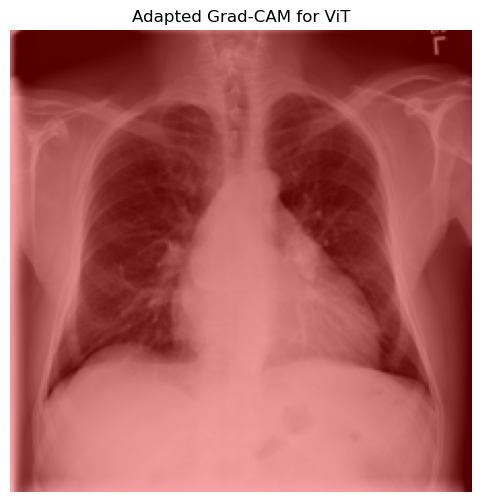

In [43]:
import os
import cv2
import torch
import timm
import types
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn

# ------------------------------
# Monkey-patch the attention block to save attention weights and retain gradients
# ------------------------------
def forward_with_attn(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)
    q = q * self.scale

    attn = (q @ k.transpose(-2, -1))  # (B, num_heads, N, N)
    attn = attn.softmax(dim=-1)
    attn = self.attn_drop(attn)

    # Save attention weights and retain gradients
    self.attn_weights = attn
    self.attn_weights.retain_grad()

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

# ------------------------------
# Load Vision Transformer (ViT) Model
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()
model.to(device)

# Monkey-patch the last attention block's forward method
target_block = model.blocks[-1].attn
target_block.forward = types.MethodType(forward_with_attn, target_block)

# ------------------------------
# Image Preprocessing Function
# ------------------------------
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image, image_tensor

# ------------------------------
# Generate Adapted Grad-CAM for ViT
# ------------------------------
def generate_adapted_gradcam(image_path):
    orig_image, input_tensor = preprocess_image(image_path)

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    score = output[0, pred_class]

    # Backward pass to compute gradients
    model.zero_grad()
    score.backward()

    # Get attention weights and gradients
    attn_weights = target_block.attn_weights.detach()
    attn_grads = target_block.attn_weights.grad.detach()

    if attn_grads.dim() != 4 or attn_weights.dim() != 4:
        print(f"Invalid shapes: grads {attn_grads.shape}, weights {attn_weights.shape}")
        return

    # Average over heads and compute CAM
    grads_mean = attn_grads.mean(dim=1)       # [1, num_tokens, num_tokens]
    weights_mean = attn_weights.mean(dim=1)   # [1, num_tokens, num_tokens]
    cam = (grads_mean * weights_mean).sum(dim=2).squeeze()  # [num_tokens]

    # Check CAM shape
    if cam.dim() == 0 or cam.shape[0] <= 1:
        print("Invalid CAM shape")
        return

    # Remove CLS token and reshape to 2D grid
    cam = cam[1:]  # Exclude CLS token
    num_patches = int(np.sqrt(cam.shape[0]))
    cam = cam.reshape(num_patches, num_patches).cpu().numpy()

    # Normalize and resize CAM
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)  # Avoid division by zero
    cam = cv2.resize(cam, (224, 224))

    # Create heatmap overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    orig_np = np.array(orig_image.resize((224, 224))) / 255.0
    overlay = heatmap + orig_np
    overlay = overlay / np.max(overlay)

    # Display result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Adapted Grad-CAM for ViT")
    plt.show()

# ------------------------------
# Example Usage
# ------------------------------
image_path = 'merged_images/00000001_000.png'  # Replace with your image path
generate_adapted_gradcam(image_path)

In [15]:
pip install timm opencv-python

Note: you may need to restart the kernel to use updated packages.
